In [2]:
pip install pandas numpy nltk gensim matplotlib scikit-learn seaborn

In [5]:
# 1. Environment Setup and Dataset Loading
import pandas as pd

# Load dataset (adjust the path if needed)
df = pd.read_csv("D:\\NLP Analysis\\Data\\Reviews.csv")

# Drop nulls and preview
df = df.dropna(subset=['Text'])
print(df[['Score', 'Text']].head())


   Score                                               Text
0      5  I have bought several of the Vitality canned d...
1      1  Product arrived labeled as Jumbo Salted Peanut...
2      4  This is a confection that has been around a fe...
3      2  If you are looking for the secret ingredient i...
4      5  Great taffy at a great price.  There was a wid...


In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download resources once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Keep 5000 reviews for performance
texts = df['Text'].head(5000).tolist()

# Setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return tokens

# Apply preprocessing
processed_texts = [preprocess(text) for text in texts]

# Show example
print(processed_texts[0])


[nltk_data] Downloading package punkt to C:\Users\solom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\solom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\solom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'product', 'found', 'good', 'quality', 'product', 'look', 'like', 'stew', 'processed', 'meat', 'smell', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Convert preprocessed tokens back to text
processed_texts_joined = [" ".join(tokens) for tokens in processed_texts]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(processed_texts_joined)

# NMF Topic Modeling
num_topics = 10  # You can experiment with this
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf)

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTOPIC {topic_idx + 1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Show top words in each topic
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(nmf_model, tfidf_feature_names, 10)



TOPIC 1:
price | store | amazon | box | buy | local | order | grocery | bag | time

TOPIC 2:
chip | bag | potato | salt | flavor | kettle | vinegar | calorie | salty | regular

TOPIC 3:
dog | food | newman | organic | year | cat | old | treat | ingredient | eat

TOPIC 4:
tea | green | drink | iced | bag | water | black | packet | leaf | drinking

TOPIC 5:
coffee | decaf | cup | strong | smooth | bitter | taste | melitta | blend | roast

TOPIC 6:
chocolate | hot | cocoa | cup | keurig | kcups | kcup | dark | best | tried

TOPIC 7:
mix | pancake | gluten | waffle | free | bisquick | make | biscuit | recipe | best

TOPIC 8:
like | good | taste | really | flavor | dont | water | little | sugar | sweet

TOPIC 9:
great | love | snack | calorie | eat | favorite | flavor | old | kid | make

TOPIC 10:
product | use | excellent | recommend | using | great | work | purchase | highly | received


K=2 => Coherence Score: 0.3383
K=3 => Coherence Score: 0.3429
K=4 => Coherence Score: 0.3561
K=5 => Coherence Score: 0.3685
K=6 => Coherence Score: 0.3837
K=7 => Coherence Score: 0.4030
K=8 => Coherence Score: 0.3983
K=9 => Coherence Score: 0.4414
K=10 => Coherence Score: 0.4950
K=11 => Coherence Score: 0.4717
K=12 => Coherence Score: 0.4806
K=13 => Coherence Score: 0.4449
K=14 => Coherence Score: 0.4528
K=15 => Coherence Score: 0.4647


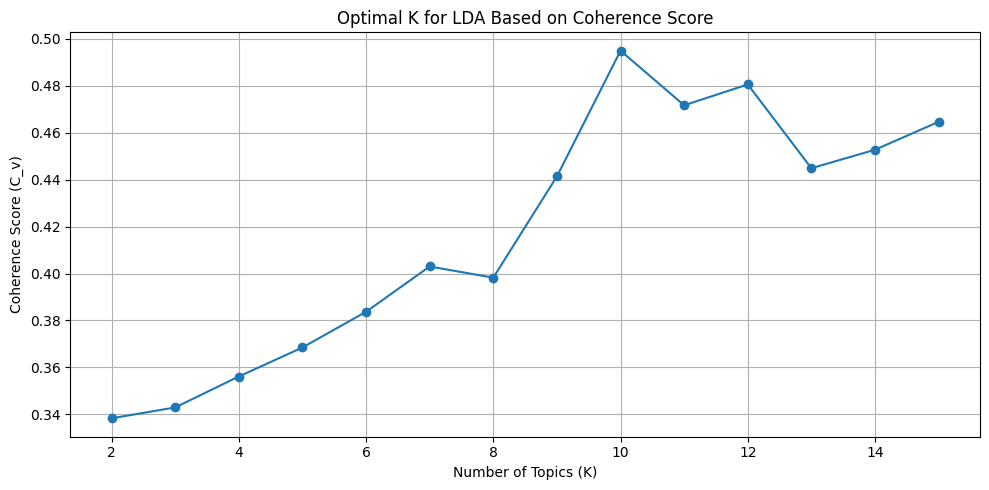

In [8]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt

# Prepare Dictionary and Corpus for Gensim
dictionary = Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Evaluate Coherence for K = 2 to 15
coherence_values = []
model_list = []
K_range = range(2, 16)

for k in K_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, 
                         random_state=42, passes=10, alpha='auto', per_word_topics=True)
    model_list.append(lda_model)
    coherence_model = CoherenceModel(model=lda_model, texts=processed_texts, 
                                     dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    print(f"K={k} => Coherence Score: {coherence_values[-1]:.4f}")

# Plot the Coherence Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, coherence_values, marker='o')
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score (C_v)")
plt.title("Optimal K for LDA Based on Coherence Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Train final LDA model with K=10
optimal_k = 10
final_lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_k, 
                           random_state=42, passes=10, alpha='auto', per_word_topics=True)

# Display topics
for idx, topic in final_lda_model.print_topics(num_topics=optimal_k, num_words=10):
    print(f"\nTOPIC {idx + 1}:")
    print(topic)



TOPIC 1:
0.046*"food" + 0.046*"dog" + 0.013*"love" + 0.013*"year" + 0.011*"newman" + 0.009*"old" + 0.009*"one" + 0.008*"eat" + 0.007*"bag" + 0.007*"great"

TOPIC 2:
0.021*"mix" + 0.016*"product" + 0.016*"make" + 0.015*"pancake" + 0.013*"great" + 0.012*"gluten" + 0.011*"free" + 0.010*"like" + 0.010*"taste" + 0.009*"good"

TOPIC 3:
0.026*"icicle" + 0.025*"mic" + 0.016*"usb" + 0.016*"blue" + 0.014*"window" + 0.013*"recording" + 0.012*"work" + 0.011*"plug" + 0.010*"computer" + 0.010*"record"

TOPIC 4:
0.037*"food" + 0.020*"organic" + 0.020*"dog" + 0.012*"ingredient" + 0.010*"newman" + 0.010*"chicken" + 0.008*"brand" + 0.007*"baby" + 0.007*"sardine" + 0.007*"love"

TOPIC 5:
0.082*"coffee" + 0.022*"taste" + 0.020*"cup" + 0.017*"flavor" + 0.014*"like" + 0.013*"decaf" + 0.010*"good" + 0.008*"one" + 0.008*"strong" + 0.008*"cocoa"

TOPIC 6:
0.018*"sinus" + 0.011*"great" + 0.008*"watery" + 0.008*"swiss" + 0.008*"set" + 0.007*"setting" + 0.006*"horse" + 0.006*"weak" + 0.006*"work" + 0.005*"paste"

In [10]:
print("\n===== 🔍 NMF Topics (TF-IDF) =====")
display_topics(nmf_model, tfidf_feature_names, 10)

print("\n===== 🔍 LDA Topics (Bag of Words) =====")
for idx, topic in final_lda_model.print_topics(num_topics=10, num_words=10):
    print(f"\nTOPIC {idx + 1}:")
    print(topic)



===== 🔍 NMF Topics (TF-IDF) =====

TOPIC 1:
price | store | amazon | box | buy | local | order | grocery | bag | time

TOPIC 2:
chip | bag | potato | salt | flavor | kettle | vinegar | calorie | salty | regular

TOPIC 3:
dog | food | newman | organic | year | cat | old | treat | ingredient | eat

TOPIC 4:
tea | green | drink | iced | bag | water | black | packet | leaf | drinking

TOPIC 5:
coffee | decaf | cup | strong | smooth | bitter | taste | melitta | blend | roast

TOPIC 6:
chocolate | hot | cocoa | cup | keurig | kcups | kcup | dark | best | tried

TOPIC 7:
mix | pancake | gluten | waffle | free | bisquick | make | biscuit | recipe | best

TOPIC 8:
like | good | taste | really | flavor | dont | water | little | sugar | sweet

TOPIC 9:
great | love | snack | calorie | eat | favorite | flavor | old | kid | make

TOPIC 10:
product | use | excellent | recommend | using | great | work | purchase | highly | received

===== 🔍 LDA Topics (Bag of Words) =====

TOPIC 1:
0.046*"food" + 0.